In [ ]:
from langgraph.graph import StateGraph ,START , END , add_messages
from typing import TypedDict , Annotated
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel , Field
import os
load_dotenv()
GROQ_API_KEY = os.getenv('GROQ_API_KEY1')

model = ChatGroq(model_name="llama3-70b-8192", api_key=GROQ_API_KEY, temperature=0.7)


In [2]:
class State(TypedDict):
    messages: Annotated[list , add_messages]
graph = StateGraph(State)

In [3]:
def chatbot(state: State):
    return {"messages": model.invoke(state['messages'])}

In [4]:
graph.add_node("chatbot" , chatbot)

graph.add_edge(START , "chatbot")
graph.add_edge("chatbot" , END)

app = graph.compile()

In [11]:
while True:
    user_input = input("user: ")
    if user_input.lower() in ["quit" , "q"]:
        print("Good Bye")
        break
    for event in app.stream({"messages": ("user" , user_input)}):
        print(event.values())
        for value in event.values():
            print(value['messages'])
            print("Assistant: " , value["messages"].content)

dict_values([{'messages': AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000152838, 'queue_time': 0.272950052, 'total_time': 0.074438552}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'finish_reason': 'stop', 'logprobs': None}, id='run--855c2e8c-6dd0-407f-bc76-49e8688b48c6-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})}])
content="Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000152838, 'queue_time': 0.272950052, 'total_time': 0.074438552}, 'model_name': 'llama3-70b-8192', 

## Langgraph with External tools

In [22]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph ,START , END , add_messages
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel , Field
from langgraph.prebuilt import tools_condition , ToolNode
import os
load_dotenv()
GROQ_API_KEY = os.getenv('GROQ_API_KEY1')

In [15]:
from langchain_community.utilities import ArxivAPIWrapper , WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun

arxiv = ArxivAPIWrapper(top_k_results=1 , doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv)

wiki = WikipediaAPIWrapper(top_k_results=1 , doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki)

In [16]:
wiki_tool.invoke('who is Mahatma Gandhi')

'Page: Family of Mahatma Gandhi\nSummary: The Gandhi family is the family of Mohandas Karamchand Gandhi (2 October 1869 – 30 January 1948), commonly known as Mahatma Gandhi; Mahatma meaning "high souled" or "venerable" in Sanskrit;  the particular term \'Mahatma\' was accorded Mohandas Gandhi for the fi'

In [20]:
tools = [wiki_tool , arxiv_tool]
model = ChatGroq(model_name="llama3-70b-8192", api_key=GROQ_API_KEY, temperature=0.7)
model_with_tool = model.bind_tools(tools=tools)

In [18]:
class State(TypedDict):
    messages: Annotated[list , add_messages]

In [21]:
def chatbot(state: State):
    return {"messages": [model_with_tool.invoke(state['messages'])]}
    

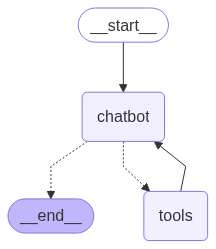

In [24]:
graph = StateGraph(State)

graph.add_node("chatbot" , chatbot)
graph.add_edge(START , "chatbot")
tool_node = ToolNode(tools=tools)
graph.add_node("tools" , tool_node)

graph.add_conditional_edges("chatbot" , tools_condition)
graph.add_edge("tools" , "chatbot")
graph.add_edge("chatbot" , END)

graph.compile()

In [25]:
app = graph.compile()

In [27]:
user_input = "What was the result of the last cricket test between India and England , if you don't know the answer use the tools provided"

result = app.stream(
    {"messages": [("user" , user_input)]} , stream_mode="values"
)

for event in result:
    event['messages'][-1].pretty_print()


================================ Human Message =================================

What was the result of the last cricket test between India and England , if you don't know the answer use the tools provided
================================== Ai Message ==================================
Tool Calls:
  wikipedia (q3nnwmkdy)
 Call ID: q3nnwmkdy
  Args:
    query: India vs England cricket test
================================= Tool Message =================================
Name: wikipedia

Page: Indian cricket team in England in 2025
Summary: The India cricket team is touring England from June to August 2025 to play the England cricket team. The tour consists of five Test matches. The series forms part of the 2025–2027 ICC World Test Championship. In August 2024, the England and Wales
================================== Ai Message ==================================
Tool Calls:
  wikipedia (b0zgm3cdw)
 Call ID: b0zgm3cdw
  Args:
    query: 2025 England vs India Test series
==================